# Surprise Reccomendation System

### This notebook was based on Susan Li Medium tutorial 
(https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b)

This is an example of collaborative reccomendation system. In a collaborative reccomendation 
system, users ara reccomended items users with similar tastes have used before. This reccomendation system has been created using the python surprise library.

## Preprocessing

In [38]:
import pandas as pd
import numpy as np
import plotly
import surprise
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
%matplotlib notebook

In [63]:
# How to load a file from a url without downloading it
# import urllib
# import io
# import zipfile
# df = urllib.request.urlopen('https://www.librec.net/datasets.html/filmtrust.zip')
# df = zipfile.Zipfile(io.BytesIO(df.read()))
# df = pd.read_table(io.BytesIO(df.read('ratings.txt')), sep = ' ', names=['UserID','MovieID','Rating'])
# df.close()

In [59]:
df = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding="latin-1")
df.columns = ['userID', 'ISBN', 'bookRating']
df.head()

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [61]:
# Deleting all the ratings equal to 0. In fact, ratings equal to zero means that the specific user has not rated the 
# corrispondent movie (is not a real rating)
df = df[df.bookRating != 0]

In [62]:
data = df['bookRating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [42]:
df.groupby('ISBN')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

,ISBN,bookRating
26378,0316666343,707
132534,0971880107,581
44961,0385504209,487
22405,0312195516,383
90207,0679781587,333
5269,0060928336,320
77942,059035342X,313
15990,0142001740,307
58853,0446672211,295
54839,044023722X,281


In [43]:
df.groupby('userID')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

,userID,bookRating
3160,11676,8524
27626,98391,5802
43027,153662,1969
52924,189835,1906
6510,23902,1395
21456,76499,1036
47780,171118,1035
65517,235105,1023
4555,16795,968
69413,248718,948


In [44]:
# Reducing dataset dimenstions, eliminating users that gave not many reviews and books that didn't get many reviews
min_book_ratings = 50
filter_books = df['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['ISBN'].isin(filter_books)) & (df['userID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(433671, 3)
The new data frame shape:	(13716, 3)


## Surprise

In [45]:
reader = surprise.Reader(rating_scale=(1, 10))
data = surprise.Dataset.load_from_df(df_new[['userID', 'ISBN', 'bookRating']], reader)

In [46]:
benchmark = []
# Iterate over all algorithms
for algorithm in [surprise.SVD(), surprise.SVDpp(), surprise.SlopeOne(), surprise.NMF(), surprise.NormalPredictor(), 
                  surprise.KNNBaseline(), surprise.KNNBasic(), surprise.KNNWithMeans(), surprise.KNNWithZScore(), 
                  surprise.BaselineOnly(), surprise.CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVD,1.544082,0.523280,0.041841
SVDpp,1.548667,3.411328,0.137042
BaselineOnly,1.551811,0.016533,0.020988
CoClustering,1.646877,0.270311,0.021151
KNNWithMeans,1.687670,0.066340,0.172606
KNNBaseline,1.693336,0.052246,0.197738
KNNWithZScore,1.711737,0.082886,0.186828
KNNBasic,1.805265,0.046291,0.195766
SlopeOne,1.819189,0.021989,0.078713


In [47]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = surprise.BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([1.5547662 , 1.55201605, 1.527474  ]),
 'fit_time': (0.013891220092773438,
  0.006448268890380859,
  0.006448507308959961),
 'test_time': (0.02628779411315918, 0.020336151123046875, 0.02132892608642578)}

In [48]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = surprise.BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 1.5128


1.5127893922427536

## Evaluation

In [49]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [53]:
df.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,125519,038550120X,9.0,8.829023,{'was_impossible': False},18,17,0.170977
1,14456,0345313860,10.0,8.298836,{'was_impossible': False},4,42,1.701164
2,78973,0446611867,7.0,7.565598,{'was_impossible': False},22,13,0.565598
3,10447,014025448X,9.0,7.754202,{'was_impossible': False},17,19,1.245798
4,16634,0380002930,10.0,8.389844,{'was_impossible': False},10,26,1.610156


In [54]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [55]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
3163,220688,0439139600,10.0,10.000000,{'was_impossible': False},24,22,0.000000
888,110912,0060173289,9.0,9.000129,{'was_impossible': False},26,8,0.000129
2771,141710,0316789089,8.0,7.999785,{'was_impossible': False},16,12,0.000215
650,218608,0345361792,9.0,8.999772,{'was_impossible': False},13,31,0.000228
810,98787,0345391802,8.0,7.998953,{'was_impossible': False},17,14,0.001047
3377,235105,043935806X,9.0,8.998281,{'was_impossible': False},17,61,0.001719
2237,163973,0449219461,8.0,7.998084,{'was_impossible': False},9,22,0.001916
3319,185308,0671028375,8.0,7.998046,{'was_impossible': False},3,15,0.001954
2207,258534,0312966970,9.0,8.996697,{'was_impossible': False},38,31,0.003303
1999,23768,0380718340,8.0,7.996355,{'was_impossible': False},9,24,0.003645


In [56]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
1311,263460,0060976845,2.0,8.087801,{'was_impossible': False},1,31,6.087801
696,105517,0452264464,1.0,7.196694,{'was_impossible': False},18,17,6.196694
3337,6563,0671021001,2.0,8.419451,{'was_impossible': False},15,37,6.419451
1897,121170,0553260111,1.0,7.683356,{'was_impossible': False},22,13,6.683356
109,236757,0553250426,1.0,7.810612,{'was_impossible': False},16,28,6.810612
1772,11676,0440222656,1.0,7.950991,{'was_impossible': False},235,19,6.950991
885,84024,0446607657,1.0,8.300525,{'was_impossible': False},6,23,7.300525
653,69971,0440212561,1.0,8.338456,{'was_impossible': False},16,25,7.338456
970,76151,067976402X,1.0,8.456288,{'was_impossible': False},7,47,7.456288
1390,6563,0684872153,1.0,8.787047,{'was_impossible': False},15,18,7.787047


<IPython.core.display.Javascript object>


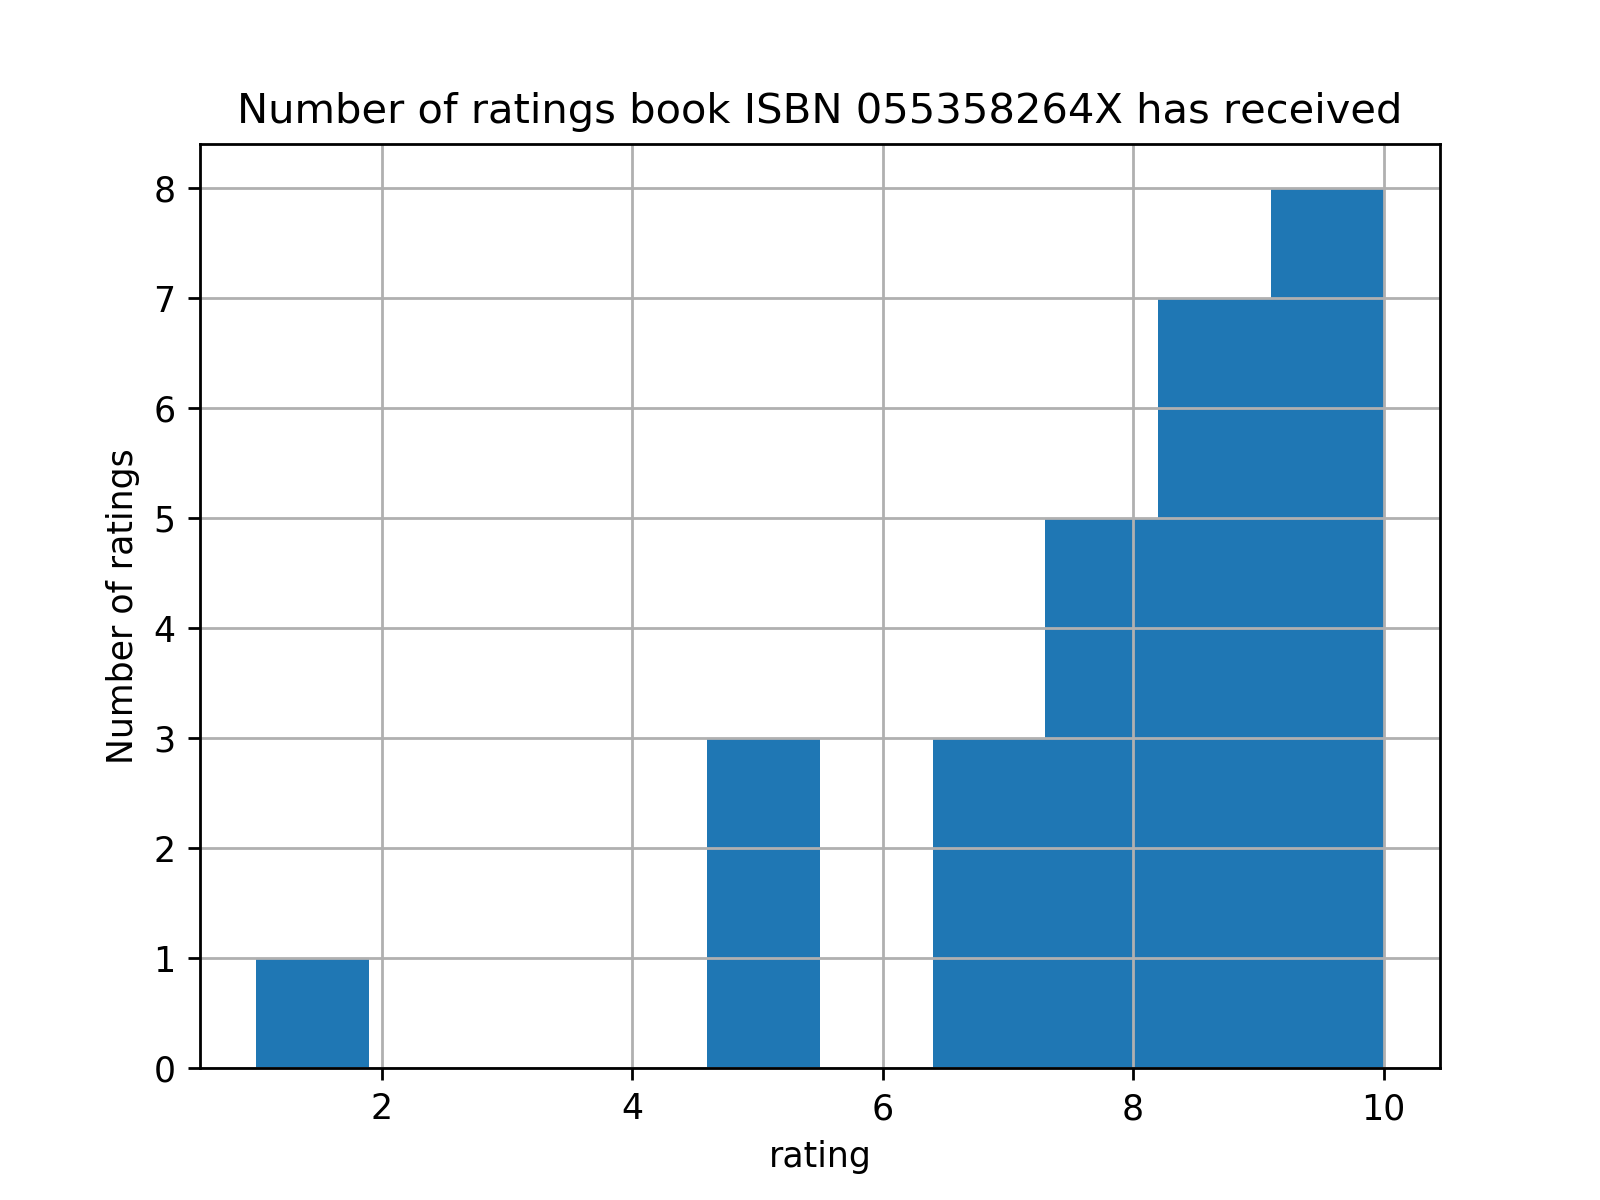

In [57]:
df_new.loc[df_new['ISBN'] == '0684872153']['bookRating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings book ISBN 055358264X has received')
plt.show();